# Bedrock Agent with LangGraph

In this notebook, we show how to use Bedrock agent in LangGraph using the BedrockAgentsRunnable construct. We will use the same example from the `bedrock_agent_roc` notebook i.e., we create a mortgage agent with two tools. The first tool will return the asset values of a given asset holder. The second tool will return the interest rate for a given asset holder with a given asset value.


### Step 1: Define the tools for the agent

In [15]:
from langchain_core.tools import tool


@tool("AssetDetail::getAssetValue")
def get_asset_value(asset_holder_id: str) -> str:
    """
    Get the asset value for an owner id

    Args:
        asset_holder_id: The asset holder id

    Returns:
        The asset value for the given asset holder

    """
    return f"The total asset value for {asset_holder_id} is 100K"


@tool("AssetDetail::getMortgageRate")
def get_mortgage_rate(asset_holder_id: str, asset_value: str) -> str:
    """
    Get the mortgage rate based on asset value

    Args:
        asset_holder_id: The asset holder id
        asset_value: The value of the asset

    Returns:
        The interest rate for the asset holder and asset value

    """
    return (
        f"The mortgage rate for {asset_holder_id} "
        f"with asset value of {asset_value} is 8.87%"
    )


tools = [get_asset_value, get_mortgage_rate]
tools

[StructuredTool(name='AssetDetail::getAssetValue', description='Get the asset value for an owner id\n\nArgs:\n    asset_holder_id: The asset holder id\n\nReturns:\n    The asset value for the given asset holder', args_schema=<class 'langchain_core.utils.pydantic.AssetDetail::getAssetValue'>, func=<function get_asset_value at 0x12193f880>),
 StructuredTool(name='AssetDetail::getMortgageRate', description='Get the mortgage rate based on asset value\n\nArgs:\n    asset_holder_id: The asset holder id\n    asset_value: The value of the asset\n\nReturns:\n    The interest rate for the asset holder and asset value', args_schema=<class 'langchain_core.utils.pydantic.AssetDetail::getMortgageRate'>, func=<function get_mortgage_rate at 0x12193d4e0>)]

### Step 2: Define the foundation model and instructions for the agent

In [16]:
foundation_model = "anthropic.claude-3-sonnet-20240229-v1:0"
foundation_model

In [3]:
instructions = "You are an agent who helps with getting the mortgage rate based on the current asset valuation"
instructions

'You are an agent who helps with getting the mortgage rate based on the current asset valuation'

### Step 3: Define the resource role to use with the Bedrock Agent

In [17]:
import boto3
import json
import time
import uuid


def _create_agent_role(agent_region, foundation_model) -> str:
    """
    Create agent resource role prior to creation of agent, at this point we do not have agentId, keep it as wildcard

    Args:
        agent_region: AWS region in which is the Agent if available
        foundational_model: The model used for inference in AWS BedrockAgents
    Returns:
        Agent execution role arn
    """
    try:
        account_id = boto3.client("sts").get_caller_identity().get("Account")
        assume_role_policy_document = json.dumps(
            {
                "Version": "2012-10-17",
                "Statement": [
                    {
                        "Effect": "Allow",
                        "Principal": {"Service": "bedrock.amazonaws.com"},
                        "Action": "sts:AssumeRole",
                        "Condition": {
                            "ArnLike": {
                                "aws:SourceArn": f"arn:aws:bedrock:{agent_region}:{account_id}:agent/*"
                            }
                        },
                    }
                ],
            }
        )
        managed_policy = {
            "Version": "2012-10-17",
            "Statement": [
                {
                    "Sid": "AmazonBedrockAgentBedrockFoundationModelStatement",
                    "Effect": "Allow",
                    "Action": "bedrock:InvokeModel",
                    "Resource": [
                        f"arn:aws:bedrock:{agent_region}::foundation-model/{foundation_model}"
                    ],
                }
            ],
        }
        role_name = f"bedrock_agent_{uuid.uuid4()}"
        iam_client = boto3.client("iam")
        response = iam_client.create_role(
            RoleName=role_name,
            AssumeRolePolicyDocument=assume_role_policy_document,
            Description="Role for Bedrock Agent",
        )
        iam_client.put_role_policy(
            RoleName=role_name,
            PolicyName=f"AmazonBedrockAgentBedrockFoundationModelPolicy_{uuid.uuid4()}",
            PolicyDocument=json.dumps(managed_policy),
        )
        time.sleep(2)
        return response.get("Role", {}).get("Arn", "")

    except Exception as exception:
        raise exception


agent_resource_role_arn = _create_agent_role(
    agent_region="us-west-2", foundation_model=foundation_model
)

agent_resource_role_arn

### Step 4: Now create the Bedrock Agent

In [ ]:
from langchain_aws.agents import BedrockAgentsRunnable

agent = BedrockAgentsRunnable.create_agent(
    agent_name="langgraph_interest_rate_agent",
    agent_resource_role_arn=agent_resource_role_arn,
    foundation_model=foundation_model,
    instruction="""
            You are an agent who helps with getting the mortgage rate based on the current asset valuation""",
    tools=tools,
)
agent

### Step 5: Define the State for your Graph

In [ ]:
import operator
from typing import TypedDict, Annotated
from typing import Union
from langchain_aws.agents import BedrockAgentAction, BedrockAgentFinish


class AgentState(TypedDict):
    """
    Defines the state for the Graph
    """

    input: str
    """Input to the agent"""
    output: Union[BedrockAgentAction, BedrockAgentFinish, None]
    """Output from the agent, could be a BedrockAgentAction or BedrockAgentFinish"""
    intermediate_steps: Annotated[list[tuple[BedrockAgentAction, str]], operator.add]
    """Intermediate steps which are tracked in the state"""

### Step 6: Define the nodes for your LangGraph

In [8]:
from langgraph.prebuilt import ToolNode


# the agent node
def run_agent(data):
    agent_outcome = agent.invoke(data)
    return {"output": agent_outcome}


# the tools node
tool_node = ToolNode(tools)


def execute_tools(data):
    # Get the most recent output - this is the key added in the `agent` above
    agent_action = data["output"]
    output = tool_node.invoke({"messages": [agent_action[0]]})
    tuple_output = agent_action[0], output["messages"][-1].content
    print(f"Tuple output is {tuple_output}")
    return {"intermediate_steps": [tuple_output]}

### Step 7: Define the conditional function to invoke the tool node or to reach end if there are no actions

In [9]:
def should_continue(data):
    output_ = data["output"]

    # If the agent outcome is a list of BedrockAgentActions, then we continue to tool execution
    if (
        isinstance(output_, list)
        and len(output_) > 0
        and isinstance(output_[0], BedrockAgentAction)
    ):
        return "continue"

    # If the agent outcome is a BedrockAgentAction, then we continue to tool execution
    if isinstance(output_, BedrockAgentAction):
        return "continue"

    # If the agent outcome is an AgentFinish, then we return `exit` string
    # This will be used when setting up the graph to define the flow
    if isinstance(output_, BedrockAgentFinish):
        return "end"

    # Unknown output from the agent, end the graph
    return "end"

### Step 8: Finally, build the graph

In [10]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", run_agent)
workflow.add_node("action", execute_tools)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

workflow.add_edge("action", "agent")

### Step 9: Compile the graph

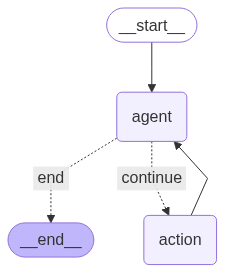

In [11]:
application = workflow.compile(debug=True)

application

### Step 10: Invoke the graph

In [ ]:
inputs = {"input": "what is my mortgage rate for id AVC-1234?"}
final_state = application.invoke(inputs)

final_state

### Step 11: Cleanup

In [13]:
def delete_agent_role(agent_resource_role_arn: str):
    """
    Delete agent resource role

    Args:
       agent_resource_role_arn: Associated Agent execution role arn
    """
    try:
        iam_client = boto3.client("iam")
        role_name = agent_resource_role_arn.split("/")[-1]
        inline_policies = iam_client.list_role_policies(RoleName=role_name)
        for inline_policy_name in inline_policies.get("PolicyNames", []):
            iam_client.delete_role_policy(
                RoleName=role_name, PolicyName=inline_policy_name
            )
        iam_client.delete_role(RoleName=role_name)
    except Exception as exception:
        raise exception


def delete_agent(agent_id):
    bedrock_client = boto3.client("bedrock-agent")
    bedrock_client.delete_agent(agentId=agent_id, skipResourceInUseCheck=True)


delete_agent(agent_id=agent.agent_id)
delete_agent_role(agent_resource_role_arn=agent_resource_role_arn)